##Data Reading and Preprocessing

In [0]:
import os
import copy
import itertools
import numpy as np
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Reading data
data = os.path.join('drive','My Drive','dl_data','QIS_EXAM_200Events')
test_input = np.load(os.path.join(data,'test_input.npy'),allow_pickle=True)
train_input = np.load(os.path.join(data,'training_input.npy'),allow_pickle=True)

test_input = test_input[()]
train_input = train_input[()]

# Segregating the test and train data
y_train = np.array([np.array([0])]*50 + [np.array([1])]*50)
y_test = np.array([np.array([0])]*50 + [np.array([1])]*50)

x_train = np.concatenate([train_input['0'],train_input['1']])
x_test = np.concatenate([test_input['0'],test_input['1']])

In [0]:
# Shuffling the dataset

def get_indices(_seed, _len):
    np.random.seed(_seed)
    indices = np.random.permutation(_len)
    return indices

indices_train = get_indices(0,len(x_train))
indices_test = get_indices(1,len(x_test))

x_train = x_train[indices_train]
y_train = y_train[indices_train]

x_test = x_train[indices_test]
y_test = y_test[indices_test]

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

###Exploratory Data Analysis

In [0]:
# 3D visualization of data points

CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # to change your point of view
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()


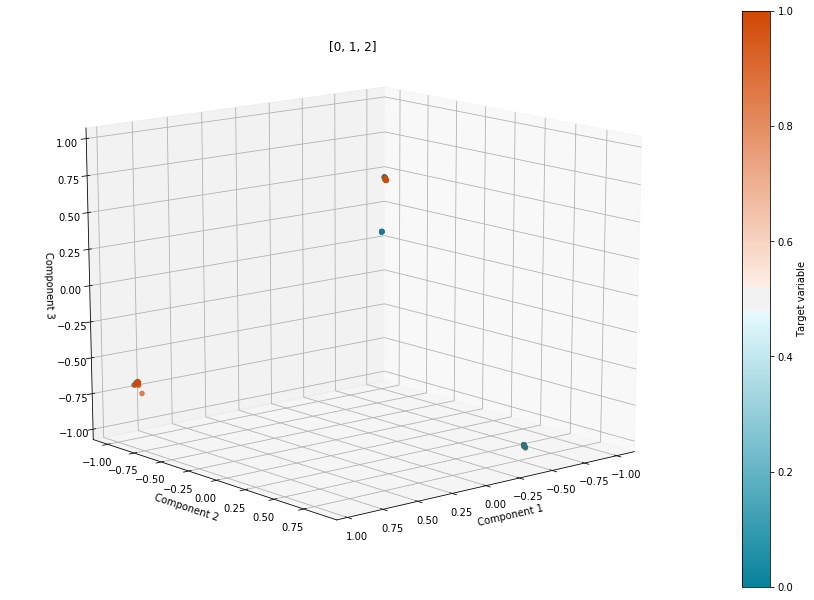

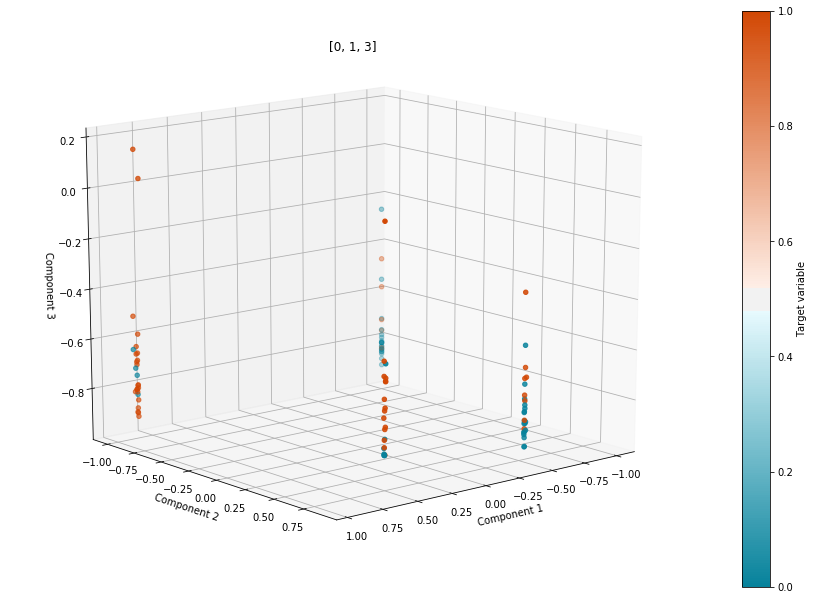

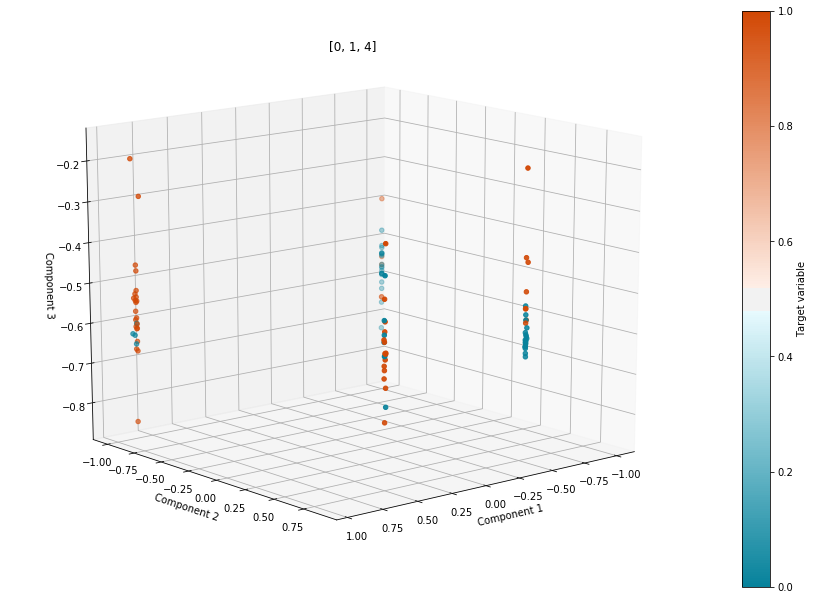

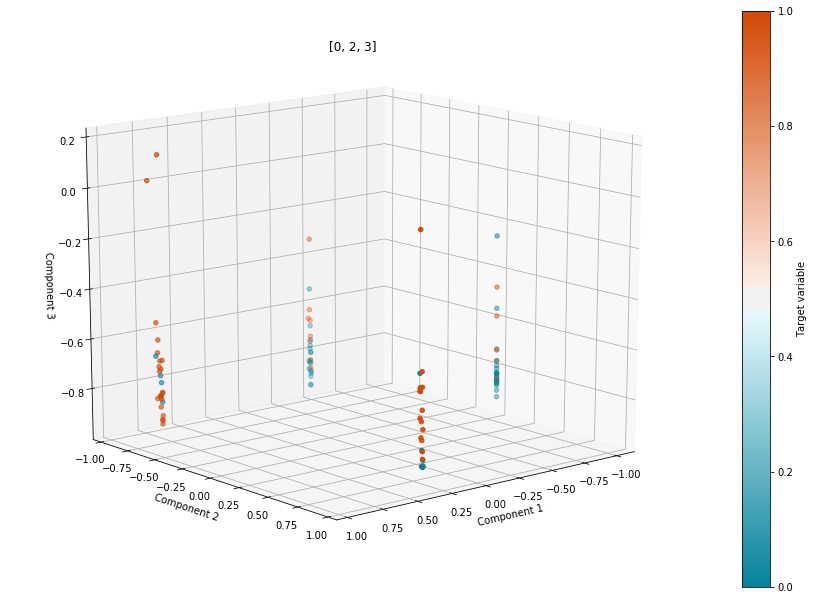

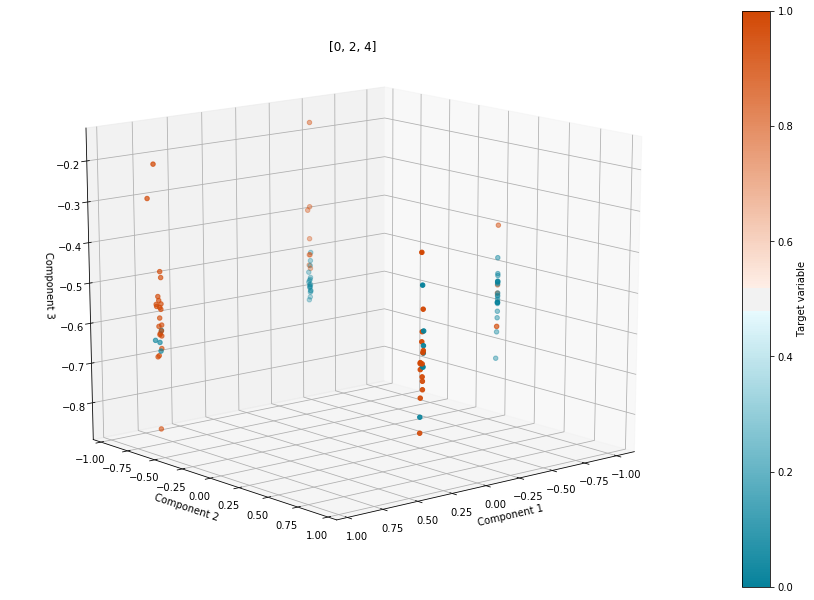

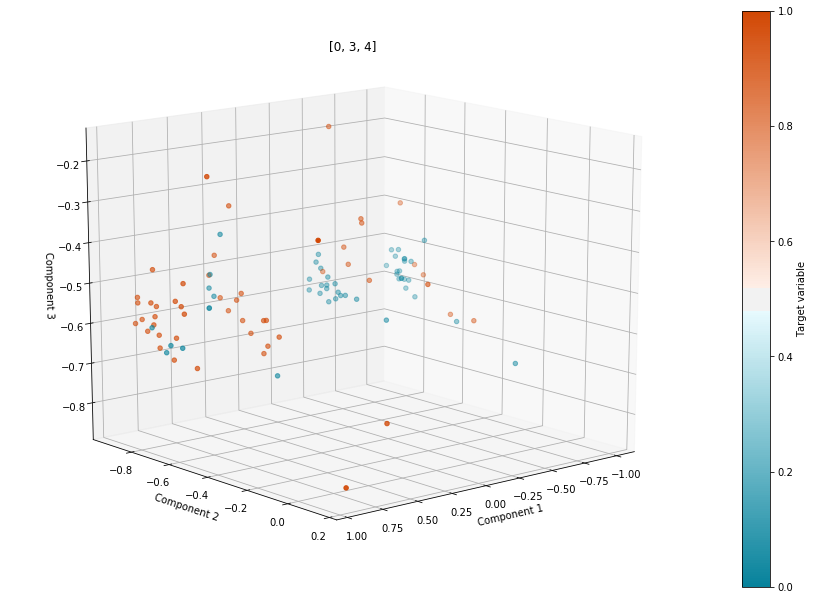

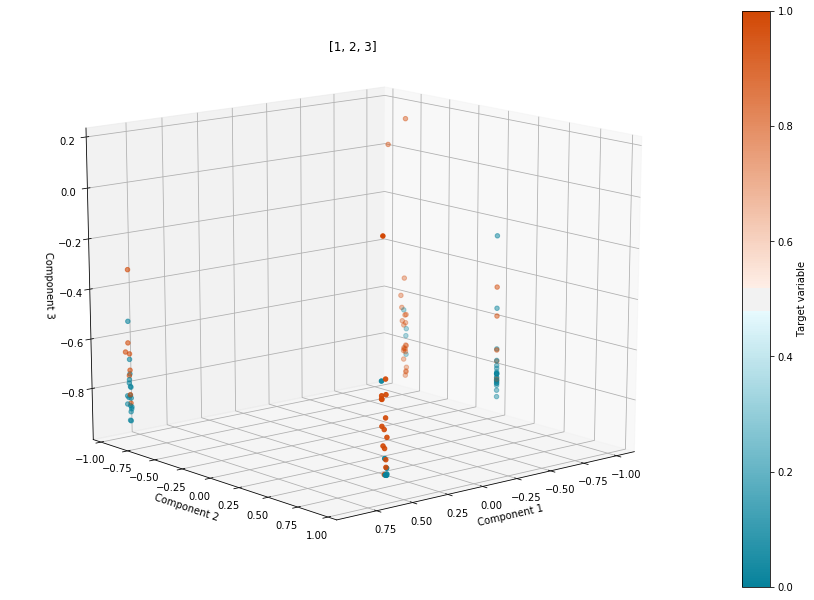

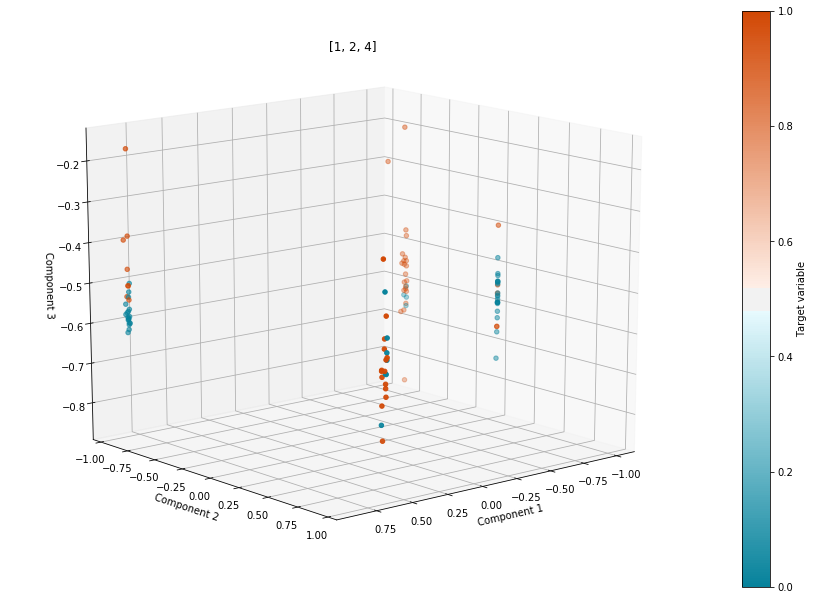

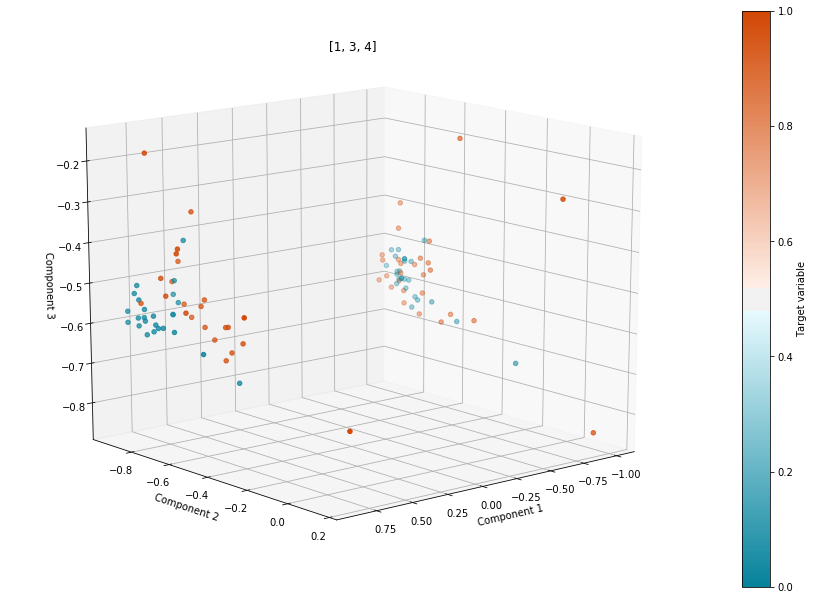

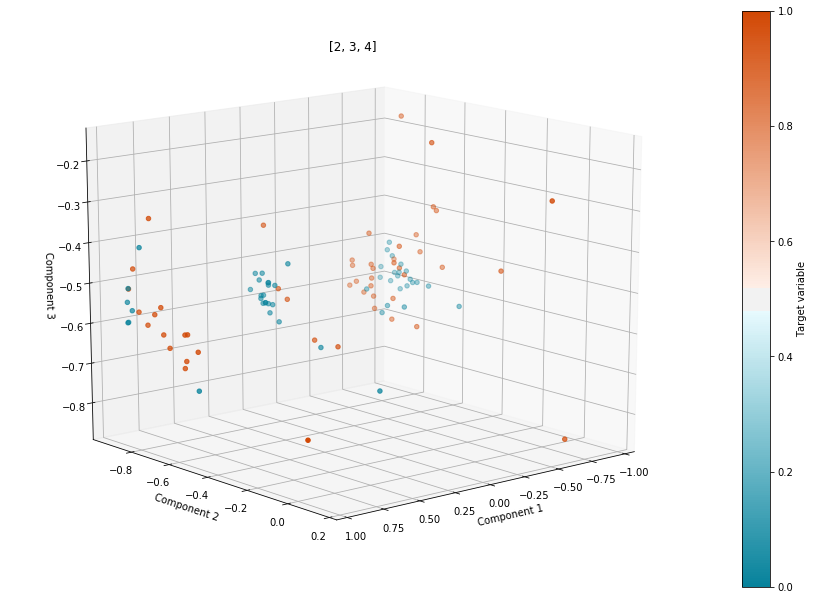

In [0]:
# Visualizing all the combinations of data to get a clear picture of classes

y = y_train.squeeze(1)
for i in range(5):
    for j in range(i+1,5):
        for k in range(j+1,5):
            arr = x_train[:,[i,j,k]]
            plot3D(arr, y, elev=15, azim=50, title=str([i,j,k]))

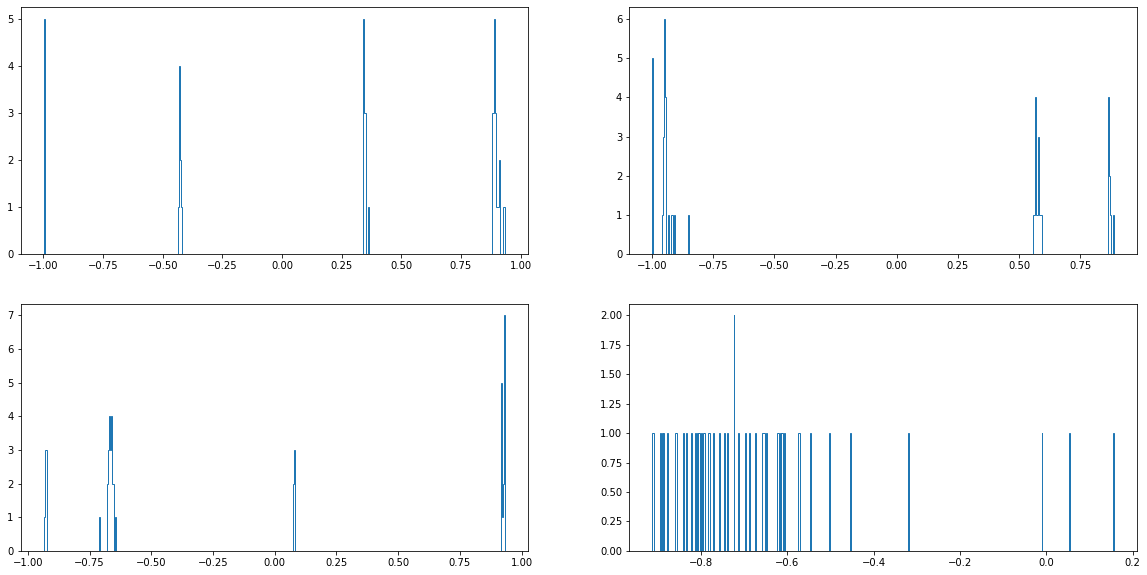

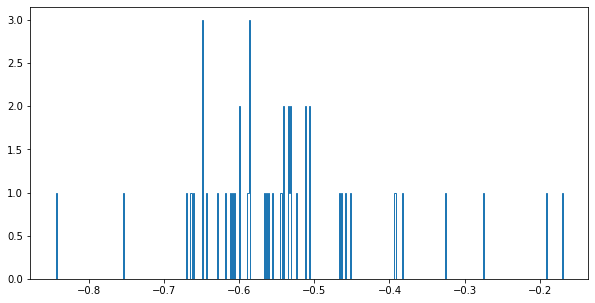

In [0]:
# signal basetrack distribution along the axis
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(x_train[y==1][:,[0]], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(x_train[y==1][:,[1]], bins=500, histtype='step')
fig.add_subplot(223)
plt.hist(x_train[y==1][:,[2]], bins=500, histtype='step')
fig.add_subplot(224)
plt.hist(x_train[y==1][:,[3]], bins=500, histtype='step')
plt.show()
fig.add_subplot(321)
fig = plt.figure(figsize = [10, 5])
plt.hist(x_train[y==1][:,[4]], bins=500, histtype='step')
plt.show()

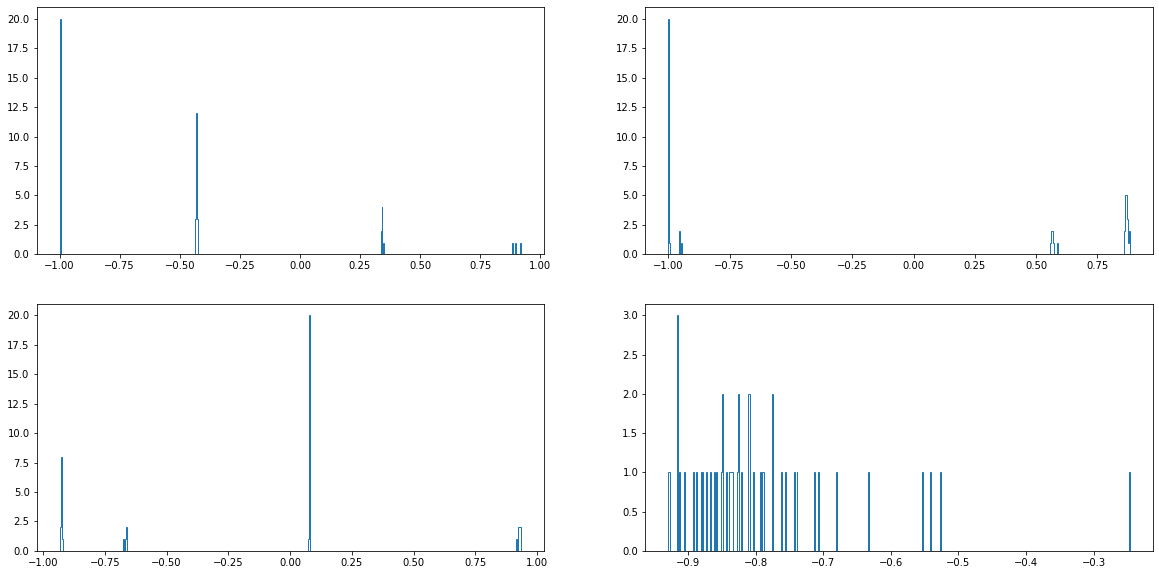

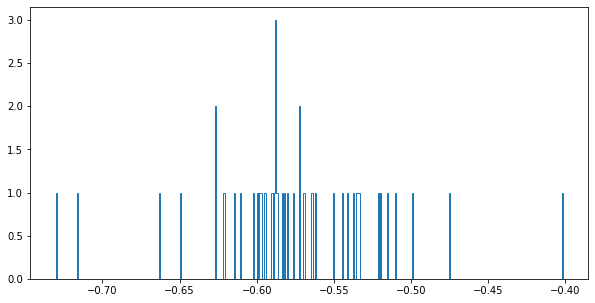

In [0]:
# background basetrack distribution along the axis
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(x_train[y==0][:,[0]], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(x_train[y==0][:,[1]], bins=500, histtype='step')
fig.add_subplot(223)
plt.hist(x_train[y==0][:,[2]], bins=500, histtype='step')
fig.add_subplot(224)
plt.hist(x_train[y==0][:,[3]], bins=500, histtype='step')
plt.show()
fig.add_subplot(321)
fig = plt.figure(figsize = [10, 5])
plt.hist(x_train[y==0][:,[4]], bins=500, histtype='step')
plt.show()

##Classification

In [0]:
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix, roc_curve,
    roc_auc_score, 
    log_loss
    )

from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [0]:
# utility function for plotting ROC-AUC
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

# Utility function to add noise
def add_noise(array, level=0.15, random_seed=34):
    numpy.random.seed(random_seed)
    return level * numpy.random.random(size=array.size) + (1 - level) * array

# Utility function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


###Keras DNN

In [0]:
# Creating a simple deep neural network
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])
    return model

In [0]:
# Concatenating the dataset to increase the dataset
x_train_nn = np.concatenate([x_train,x_test])
y_train_nn = np.concatenate([y_train,y_test])

# Normalizing the dataset
transformer = Normalizer()
X_train_norm = transformer.fit_transform(x_train_nn)
X_train_norm = x_train_nn

# Using 20% data for testing
x_test_nn = X_train_norm[int(0.8*len(X_train_norm)):]
y_test_nn = y_train_nn[int(0.8*len(X_train_norm)):]

# Using 80% data for training
x_train_nn = X_train_norm[:int(0.8*len(X_train_norm))]
y_train_nn = y_train_nn[:int(0.8*len(X_train_norm))]


callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto'),
             ModelCheckpoint('output/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

# Creating model
nn = nn_model(x_train_nn.shape[1])

# Training. Using 20% of data for validation
history = nn.fit(x_train_nn, y_train_nn, validation_split=0.2, epochs=50, 
       verbose=1, batch_size=8, shuffle=True)


Train on 128 samples, validate on 32 samples
Epoch 1/50
128/128 [==============================] - 1s 5ms/step - loss: 0.6825 - acc: 0.5625 - val_loss: 0.7178 - val_acc: 0.3750
Epoch 2/50
128/128 [==============================] - 0s 901us/step - loss: 0.6725 - acc: 0.5781 - val_loss: 0.7493 - val_acc: 0.3750
Epoch 3/50
128/128 [==============================] - 0s 786us/step - loss: 0.6417 - acc: 0.6562 - val_loss: 0.7913 - val_acc: 0.3750
Epoch 4/50
128/128 [==============================] - 0s 863us/step - loss: 0.6413 - acc: 0.6719 - val_loss: 0.8197 - val_acc: 0.3750
Epoch 5/50
128/128 [==============================] - 0s 826us/step - loss: 0.6230 - acc: 0.6562 - val_loss: 0.8762 - val_acc: 0.3750
Epoch 6/50
128/128 [==============================] - 0s 779us/step - loss: 0.6432 - acc: 0.6406 - val_loss: 0.8738 - val_acc: 0.3750
Epoch 7/50
128/128 [==============================] - 0s 761us/step - loss: 0.6282 - acc: 0.6719 - val_loss: 0.8906 - val_acc: 0.3750
Epoch 8/50
128/128 

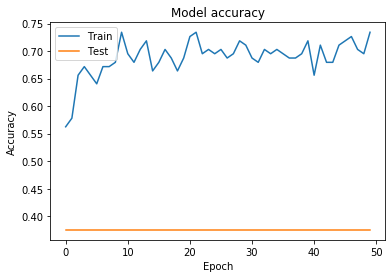

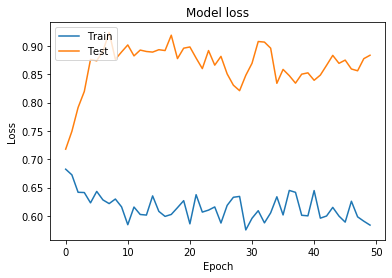

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Test loss: 0.8740641403198243
Test accuracy: 0.45


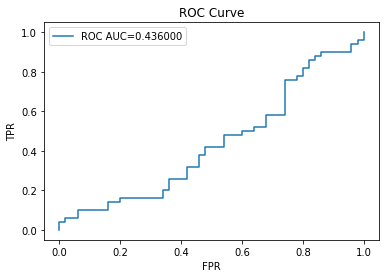

In [0]:
# Calculating test loss and accuracy
score = nn.evaluate(x_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plotting ROC-AUC curve
y_pred_nn = nn.predict_proba(x_test)
plot_metrics(y_test, y_pred_nn)

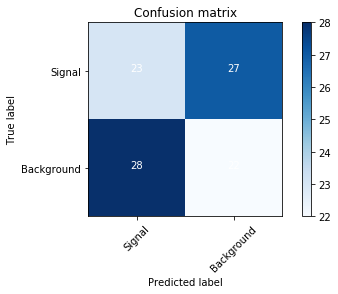

In [0]:
# creating classification data
y_class = y_pred_nn.copy()
y_class[y_class>0.5]=1
y_class[y_class<=0.5]=0

# Confusing matrix
confusion_mtx = confusion_matrix(y_test, y_class)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

### XGBClassifier

In [0]:
param_grid = {
        'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
        'max_depth':[100],

}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(
    XGBClassifier_tmp(learning_rate=0.005, subsample=0.8,
                        colsample_bytree=0.8, n_jobs=20), 
    param_grid=param_grid, n_jobs=5,
    scoring='roc_auc',
    cv=StratifiedKFold(7, shuffle=True, random_state=0),
    verbose=7)

In [0]:
clf.fit(x_train, y_train)
clf.best_estimator_

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done  70 out of  70 | elapsed:   11.8s finished


XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.8, gamma=0,
                  learning_rate=0.005, max_delta_step=0, max_depth=100,
                  min_child_weight=1, missing=None, n_estimators=80, n_jobs=20,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                  silent=None, subsample=0.8, verbosity=1)

Accuracy: 0.45
Precision: 0.4528301886792453
Recall: 0.48


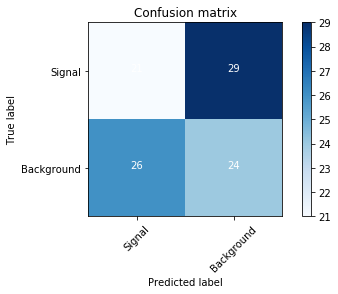

In [0]:
y_pred_xgb = clf.predict(x_test)
y_class = y_pred_xgb.copy()
y_class[y_class>0.5]=1
y_class[y_class<=0.5]=0
print("Accuracy:",metrics.accuracy_score(y_test.squeeze(1), y_class))
print("Precision:",metrics.precision_score(y_test, y_class))
print("Recall:",metrics.recall_score(y_test, y_class))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_class)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

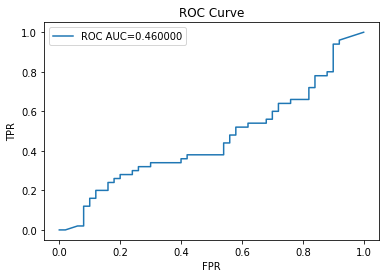

In [0]:
# plotting ROC-AUC curve
y_pred_nn = nn.predict_proba(x_test)
plot_metrics(y_test, y_pred_xgb)

###AdaBoostClassifier

In [0]:
clf = AdaBoostClassifier(n_estimators=120, learning_rate=0.009, random_state=13,
                             base_estimator=DecisionTreeClassifier(max_depth=19, min_samples_leaf=40, max_features=2,
                                                                    random_state=13))
clf.fit(x_train, y_train.squeeze(1))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=19,
                                                         max_features=2,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=40,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                           

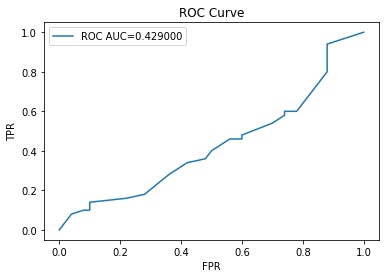

In [0]:
y_pred_ada = clf.predict_proba(x_test)[:, 1]
plot_metrics(y_test, y_pred_ada)

Accuracy: 0.45
Precision: 0.4444444444444444
Recall: 0.4


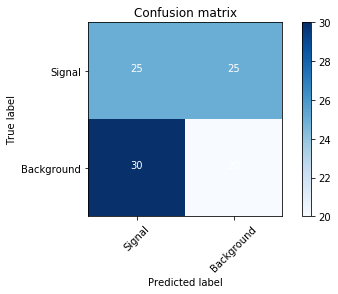

In [0]:
y_class = y_pred_ada.copy()
y_class[y_class>0.5]=1
y_class[y_class<=0.5]=0
print("Accuracy:",metrics.accuracy_score(y_test.squeeze(1), y_class))
print("Precision:",metrics.precision_score(y_test, y_class))
print("Recall:",metrics.recall_score(y_test, y_class))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_class)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

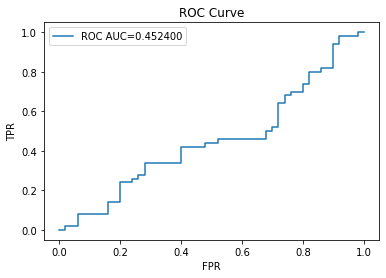

In [0]:
# Adding Noise
y_pred_ada = add_noise(clf.predict_proba(x_test)[:, 1])
plot_metrics(y_test, y_pred_ada)

###GradientBoostingClassifier

In [0]:
%time 
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.8, random_state=13,
                                min_samples_leaf=1, max_depth=3)
gb.fit(x_train_scale, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=13, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Log Loss: 1.3733057294268327
Accuracy: 0.52
Precision: 0.52
Recall: 0.52


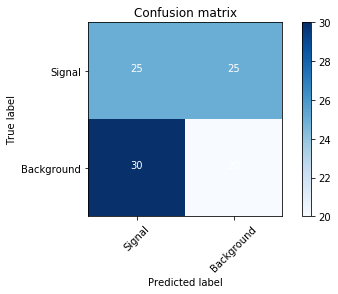

In [0]:
proba_gb = gb.predict_proba(x_test_scale)
proba_class = proba_gb.copy()
proba_class = proba_class[:, 1]
proba_class[proba_class>0.5]=1
proba_class[proba_class<=0.5]=0

print ("Log Loss:", log_loss(y_test, proba_gb))
print("Accuracy:",metrics.accuracy_score(y_test.squeeze(1), proba_class))
print("Precision:",metrics.precision_score(y_test, proba_class))
print("Recall:",metrics.recall_score(y_test, proba_class))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_class)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

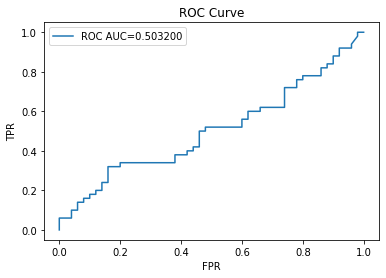

In [0]:
plot_metrics(y_test, proba_gb[:,1])

###Support Vector Machine

Accuracy: 0.46
Precision: 0.46296296296296297
Recall: 0.5


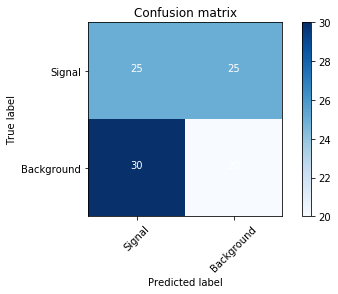

In [0]:
clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train_scale, y_train)
y_pred_svm = clf.predict(x_test_scale)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision:",metrics.precision_score(y_test, y_pred_svm))
print("Recall:",metrics.recall_score(y_test, y_pred_svm))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_class)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

###KNeighborsClassifier

Accuracy: 0.49
Precision: 0.48936170212765956
Recall: 0.46


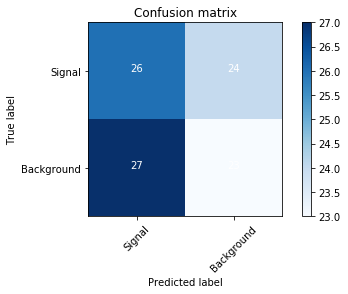

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(x_train_scale, y_train)
y_pred_knn = clf.predict(x_test_scale)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))
print("Precision:",metrics.precision_score(y_test, y_pred_knn))
print("Recall:",metrics.recall_score(y_test, y_pred_knn))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

###LogisticRegression

Accuracy: 0.47
Precision: 0.4716981132075472
Recall: 0.5


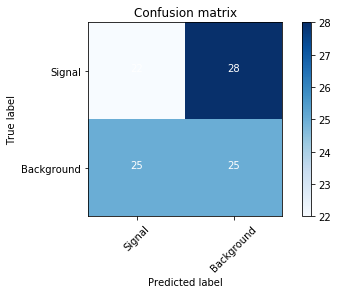

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(x_train_scale,y_train)
y_pred_lr = clf.predict(x_test_scale)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

###DecisionTreeClassifier

Accuracy: 0.52
Precision: 0.52
Recall: 0.52


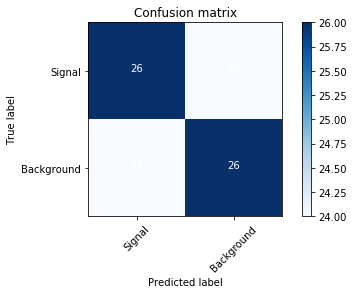

In [0]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred_dt = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dt))
print("Precision:",metrics.precision_score(y_test, y_pred_dt))
print("Recall:",metrics.recall_score(y_test, y_pred_dt))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])

###RandomForestClassifier

Accuracy: 0.52
Precision: 0.52
Recall: 0.52


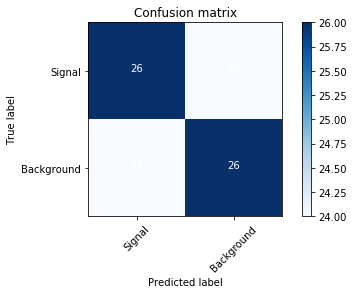

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x_train, y_train)
y_pred_rfc = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rfc))
print("Precision:",metrics.precision_score(y_test, y_pred_rfc))
print("Recall:",metrics.recall_score(y_test, y_pred_rfc))

# confusing matrix
confusion_mtx = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(confusion_mtx, ['Signal','Background'])